In [3]:
import tkinter as tk
from tkinter import *
import tkinter.messagebox
import pyaudio
import wave
import os
import numpy as np
import math
import operator

In [4]:
from nnmnkwii.datasets import PaddedFileSourceDataset
from nnmnkwii.datasets.cmu_arctic import CMUArcticWavFileDataSource
from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames, delta_features
from nnmnkwii.util import apply_each2d_trim
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from os.path import basename, splitext
import os
import sys
import time

import numpy as np
from scipy.io import wavfile
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
import librosa.display
import IPython
from IPython.display import Audio
import matplotlib.pyplot as plt
import pickle

In [5]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
FILE_NAME = 'input/voice.wav'

In [6]:
p = pyaudio.PyAudio()
recording = 0
frames = []

In [7]:
stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

In [8]:
def start_record():
    recording = 1
    frames.clear()
    label['text'] = 'Đang ghi âm'
    stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)
    while recording == 1:
        data = stream.read(CHUNK)
        frames.append(data)
        window.update()

In [9]:
def stop_record(): 
    recording = 0
    label['text'] = 'Ghi âm xong'
    print('* stop recording')
    stream.stop_stream()
    stream.close()
    global FILE_NAME
    FILE_NAME = 'input/voice.wav'
    wf = wave.open(FILE_NAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

In [10]:
import sounddevice as sd

In [11]:
def play_wav(c):
    global waveform
    if c==1:
        fs, x =  wavfile.read(FILE_NAME)
    else:
        fs, x =  wavfile.read('output/voice.wav')
    plt.plot(x)
    plt.show()
    sd.play(x, fs)

In [12]:
fftlen = pyworld.get_cheaptrick_fft_size(RATE)
alpha = pysptk.util.mcepalpha(RATE)
order = 24
frame_period = 5
hop_length = int(RATE * (frame_period * 0.001))
max_files = 100 # number of utterances to be used.
test_size = 0.03
use_delta = True

In [13]:
if use_delta:
    windows = [
        (0, 0, np.array([1.0])),
        (1, 1, np.array([-0.5, 0.0, 0.5])),
        (1, 1, np.array([1.0, -2.0, 1.0])),
    ]
else:
    windows = [
        (0, 0, np.array([1.0])),
    ]

In [33]:
def import_model(c):
    label['text'] = 'Đang chuyển'
    title_model['text'] = c
    with open("models/" + c + ".pkl", "rb") as file: 
        gmm=pickle.load(file)
    src_path=FILE_NAME
    tgt_path="output/voice.wav"
    w_MLPG = test_one_utt(src_path, gmm, disable_mlpg=False)
    w_MLPG = np.asarray(w_MLPG, dtype=np.int16)
    wavfile.write(tgt_path, RATE, w_MLPG)
    label['text'] = 'Chuyển xong'

In [15]:
def test_one_utt(src_path, gmm, disable_mlpg=False, diffvc=False):
    # GMM-based parameter generation is provided by the library in `baseline` module
    if disable_mlpg:
        # Force disable MLPG
        paramgen = MLPG(gmm, windows=[(0,0, np.array([1.0]))], diff=diffvc)
    else:
        paramgen = MLPG(gmm, windows=windows, diff=diffvc)

    fs, x = wavfile.read(src_path)
    print(x)
    x = x.astype(np.float64)
    if len(x.shape)==2:
        x=x.sum(axis=1)/2
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)

    mc = pysptk.sp2mc(spectrogram, order=order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    if use_delta:
        mc = delta_features(mc, windows)
    mc = paramgen.transform(mc)
    #if disable_mlpg and mc.shape[-1] != static_dim:
    #    mc = mc[:,:static_dim]
    #assert mc.shape[-1] == static_dim
    mc = np.hstack((c0[:, None], mc))
    if diffvc:
        mc[:, 0] = 0 # remove power coefficients
        engine = Synthesizer(MLSADF(order=order, alpha=alpha), hopsize=hop_length)
        b = pysptk.mc2b(mc.astype(np.float64), alpha=alpha)
        waveform = engine.synthesis(x, b)
    else:
        spectrogram = pysptk.mc2sp(
            mc.astype(np.float64), alpha=alpha, fftlen=fftlen)
        waveform = pyworld.synthesize(
            f0, spectrogram, aperiodicity, fs, frame_period)
        
    return waveform

In [16]:
from tkinter.filedialog import askopenfilename
def open_file():
    global FILE_NAME
    FILE_NAME = askopenfilename(initialdir = "/home", title = "Select file", filetypes =[('file audio', '*.wav')]) 

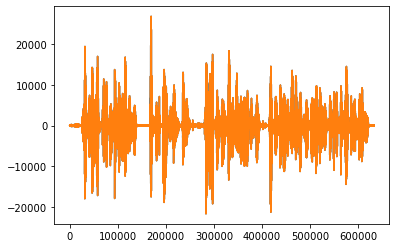

[[ 4  4]
 [-1  0]
 [-5 -5]
 ...
 [38 38]
 [34 35]
 [24 24]]


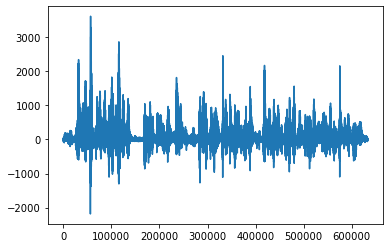

In [34]:
window = tk.Tk()
window.geometry('500x300')
window.title('Voice conversion')
model_names = [
    'dong',
    'quang',
    'duc',
    'an',
    'tuyen',
    'thang'
]
button_model = tk.Frame(window, padx=150, pady=150)
button_model.pack(fill=BOTH)
title_model = Menubutton(button_model, width=20, padx=10,
                                pady=5, relief=RAISED)
title_model.grid(row=0, column=0, padx=20, pady=5)
title_model['text'] = 'Chọn giọng chuyển'
title_model.menu = Menu(title_model)
title_model["menu"] = title_model.menu
for c in model_names:
    title_model.menu.add_command(label=c, command=lambda c=c: import_model(c))
button_start = tk.Button(window, text='Ghi âm', width=15, command=start_record)
button_start.place(x=30, y=50)
button_stop = tk.Button(window, text='Dừng ghi âm', width=15, command=stop_record)
button_stop.place(x=150, y=50)
label_2 = tk.Label(window, text='hoặc')
label_2.place(x=300, y=50)
button_open_file = tk.Button(window, text='Chọn file', width=15, command=open_file)
button_open_file.place(x=350, y=50)
button_play = tk.Button(window, text='Phát lại', width=15, command=lambda c=1: play_wav(c))
button_play.place(x=190, y=100)
button_play_2 = tk.Button(window, text='Kiểm tra', width=15, command=lambda c=2: play_wav(c))
button_play_2.place(x=190, y=200)
label = tk.Label(window)
label.place(x=220, y=250)
tk.mainloop()